# Partial re-implementation of [Prior-aware autoencoders for lung pathology segmentation](https://www.sciencedirect.com/science/article/pii/S1361841522001384)

This paper is made up by 3 models:

1. a Partial Convolutionl Neural Network (PCNN) written as an autoencoder
2. a Normal Appearance Autoencoder model (NAA)
3. the Prior UNet which predicts the lung pathology segmentation mask.

This notebook will implement 2 and 3 the same way as the paper, but will the [Semantic Diffusion Model](https://github.com/WeilunWang/semantic-diffusion-model) instead for 1.

In [1]:
# !pip install torch numpy Pillow torchsummary torchvision matplotlib

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.transforms as transforms
import torch.nn.functional as F


import cv2
import os

import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm


(array([65527,     0,     0,     0,     2,     3,     1,     0,     1,
            2]),
 array([  0. ,  19.4,  38.8,  58.2,  77.6,  97. , 116.4, 135.8, 155.2,
        174.6, 194. ]))

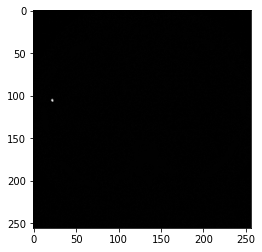

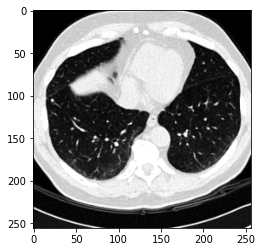

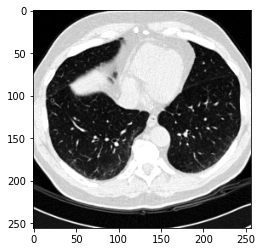

In [3]:

lesion_images = sorted(glob('/home/user/data/prior_train/gt/*.png'))
lesion_free_images = sorted(glob('/home/user/data/prior_train/inpainted/*.png'))

lesion_free_image = cv2.imread(lesion_free_images[1], 0)
lesion_image = cv2.imread(lesion_images[1], 0)

q05 = np.quantile(lesion_free_image, 0.05)
q95 = np.quantile(lesion_free_image, 0.95)
lesion_free_image = np.clip(lesion_free_image, q05, q95)

q05 = np.quantile(lesion_image, 0.05)
q95 = np.quantile(lesion_image, 0.95)
lesion_image = np.clip(lesion_image, q05, q95)

plt.figure(); plt.imshow(np.abs(lesion_free_image - lesion_image), cmap='gray')
plt.figure(); plt.imshow(lesion_image, cmap='gray')
plt.figure(); plt.imshow(lesion_free_image, cmap='gray')

t = np.abs(lesion_free_image - lesion_image)
np.histogram(t)

## Module 1: Semantic Diffusion Model

The diffusion model has been trained and should be able to perform inference using the /scripts/luna16.sh script in the SDM folder.
Here, we only prepare the dataset that can be used to train the NAA model.

In [4]:
# Directly inference from the trained SDM model to generate pathlogy free images
# by running the /scripts/luna16.sh under the Semantic Diffusion Model directory

# Prepare training and test dataset
LESION_PATH = '/home/user/data/prior_train/gt'
LESION_FREE_PATH = '/home/user/data/prior_train/inpainted'


class NAAImageDataset(Dataset):
    def __init__(self, lesion_path, lesion_free_path):
        self.lesion_images = sorted(glob(os.path.join(lesion_path, '*.png')))
        self.lesion_free_images = sorted(glob(os.path.join(lesion_free_path, '*.png')))
    
    def __len__(self):
          return len(self.lesion_images)
    
    def __getitem__(self, idx):
        lesion_image = cv2.imread(self.lesion_images[idx], 0)[..., None]
        lesion_free_image = cv2.imread(self.lesion_free_images[idx], 0)[..., None]
        
        q05 = np.quantile(lesion_image, 0.05)
        q95 = np.quantile(lesion_image, 0.95)
        lesion_image = np.clip(lesion_image, q05, q95).astype('float32')
        
        q05 = np.quantile(lesion_free_image, 0.05)
        q95 = np.quantile(lesion_free_image, 0.95)
        lesion_free_image = np.clip(lesion_free_image, q05, q95).astype('float32')
        
        return transforms.ToTensor()(lesion_image) / 255., transforms.ToTensor()(lesion_free_image) / 255.

In [5]:
dataset = NAAImageDataset(LESION_PATH, LESION_FREE_PATH)

# randomly split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])  ## is the seed set? will this give a different split every time?

# create dataloaders for train and test sets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

## Module 2: Normal Appearance Autoencoder

In [10]:
# Define the Normal Apperance Autoencoder (NAA). It consists of an input layer of size 512, 5 hidden layers of size 256, 128, 64, 64, 64 and a sampling layer for mean and logvar of size 64
# Define a convolution layer where each conv block consists of a conv2d layer, a batchnorm layer, then another conv2d layer followed by another batch normalization layer and finally a relu layer
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
        super(ConvBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
            nn.LeakyReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding, bias=bias),
            nn.LeakyReLU(),
            nn.BatchNorm2d(out_channels),
        )
    def forward(self, x):
        return self.layers(x)


class NAA(nn.Module):
    def __init__(self):
        super(NAA, self).__init__()
        
        # Input: 1x512x512 image, Output: 128x128x128 latent-z
        self.encoder = torch.nn.Sequential(
            ConvBlock(1, 8, kernel_size=3),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            ConvBlock(8, 16, kernel_size=3),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            ConvBlock(16, 32, kernel_size=3),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            ConvBlock(32, 64, kernel_size=3),
            nn.Dropout(0.2),
            ConvBlock(64, 128, kernel_size=3),
            nn.Dropout(0.2),
        )
        
        # Input 128x128x128 latent-z, Output: 1x512x512 image
        self.decoder = torch.nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            ConvBlock(128, 128, kernel_size=3),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            ConvBlock(64, 64, kernel_size=3),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            ConvBlock(32, 32, kernel_size=3),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            ConvBlock(16, 16, kernel_size=3),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            ConvBlock(8, 8, kernel_size=3),
            nn.Conv2d(8, 1, kernel_size=1, stride=1)
        )

        self.mean = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.logvar = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        
    def sample(self, batch_size=1, eps=None):
        if eps is None:
            eps = torch.randn(size=(batch_size, 128, 64, 64))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        x = self.encoder(x)
        return self.mean(x), self.logvar(x)

    def reparameterize(self, mean, logvar):
        eps = torch.randn_like(mean)        
        return eps * torch.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            return torch.sigmoid(logits)
        return logits

    
def log_normal_pdf(sample, mean, logvar, raxis=(1, 2, 3)):
    log2pi = torch.log(2 * torch.ones(1) * np.pi).to('cuda')
    return torch.sum(
        -.5 * ((sample - mean) ** 2. * torch.exp(-logvar) + logvar + log2pi),
        dim=raxis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = torch.binary_cross_entropy_with_logits(input=x_logit, target=x)
    logpx_z = -torch.sum(cross_ent, dim=[1, 2, 3])
    logpz = log_normal_pdf(z, torch.zeros(1, device='cuda'), torch.zeros(1, device='cuda'))
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -torch.mean(logpx_z + logpz - logqz_x)
    # return -torch.mean(logpx_z)

In [16]:
# from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = NAA().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
# summary(model, input_size=(1, 512, 512))

# import gc
# model = model.cpu()
# del model
# gc.collect()
# torch.cuda.empty_cache()

cuda
Total number of parameters is: 1417385


: 

In [12]:
from torch.optim.lr_scheduler import ExponentialLR

model = NAA().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.8)
num_epochs = 40


print("Training begins!")

for epoch in range(num_epochs):
    model.train()
    print(f"Epoch {epoch} begins:")
    t = tqdm(train_dataloader, unit="batch")
    for batch_idx, (lesion, lesion_free) in enumerate(t):
        lesion = lesion.to(device)
        lesion_free = lesion_free.to(device)
        optimizer.zero_grad()
        loss = compute_loss(model, lesion)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 20 == 0:
            t.set_description(f"Epoch {epoch} / {num_epochs}, batch {batch_idx}, Loss: {loss / len(lesion)}")
            t.set_postfix(loss=loss.item()/len(lesion))
    scheduler.step()

    model.eval()
    
    with torch.no_grad():
        t = tqdm(test_dataloader, unit="batch")
        for batch_idx, (lesion, lesion_free) in enumerate(t):
            lesion = lesion.to(device)
            lesion_free = lesion_free.to(device)
            loss = compute_loss(model, lesion)
            if batch_idx % 20 == 0:
                t.set_description(f"Validation loss: {loss / len(lesion)}")


Training begins!
Epoch 0 begins:


Validation loss: 1377.6864013671875: 100%|██████████| 8/8 [00:01<00:00,  4.71batch/s]


Epoch 1 begins:


Validation loss: 1088.83056640625: 100%|██████████| 8/8 [00:01<00:00,  4.70batch/s]


Epoch 2 begins:


Validation loss: 1099.0810546875: 100%|██████████| 8/8 [00:01<00:00,  4.75batch/s]


Epoch 3 begins:


Validation loss: 1085.471435546875: 100%|██████████| 8/8 [00:01<00:00,  4.70batch/s]


Epoch 4 begins:


Validation loss: 1105.329833984375: 100%|██████████| 8/8 [00:01<00:00,  4.62batch/s]


Epoch 5 begins:


Validation loss: 1045.659423828125: 100%|██████████| 8/8 [00:01<00:00,  4.80batch/s]


Epoch 6 begins:


Validation loss: 1089.536376953125: 100%|██████████| 8/8 [00:01<00:00,  4.73batch/s]


Epoch 7 begins:


Validation loss: 1045.680419921875: 100%|██████████| 8/8 [00:01<00:00,  4.82batch/s]


Epoch 8 begins:


Validation loss: 1036.47412109375: 100%|██████████| 8/8 [00:01<00:00,  4.78batch/s]


Epoch 9 begins:


Validation loss: 1042.347412109375: 100%|██████████| 8/8 [00:01<00:00,  4.77batch/s]


Epoch 10 begins:


Epoch 10 / 40, batch 20, Loss: 1064.0128173828125: 100%|██████████| 29/29 [00:07<00:00,  4.03batch/s, loss=1.06e+3]
Validation loss: 1043.2186279296875: 100%|██████████| 8/8 [00:01<00:00,  4.75batch/s]


Epoch 11 begins:


Validation loss: 1157.858642578125: 100%|██████████| 8/8 [00:01<00:00,  4.73batch/s]


Epoch 12 begins:


Epoch 12 / 40, batch 20, Loss: 1065.4742431640625: 100%|██████████| 29/29 [00:07<00:00,  4.06batch/s, loss=1.07e+3]
Validation loss: 1061.41455078125: 100%|██████████| 8/8 [00:01<00:00,  4.82batch/s]


Epoch 13 begins:


Validation loss: 1020.5797119140625: 100%|██████████| 8/8 [00:01<00:00,  4.66batch/s]


Epoch 14 begins:


Epoch 14 / 40, batch 20, Loss: 1064.4031982421875: 100%|██████████| 29/29 [00:07<00:00,  4.01batch/s, loss=1.06e+3]
Validation loss: 996.3956298828125: 100%|██████████| 8/8 [00:01<00:00,  4.74batch/s]


Epoch 15 begins:


Validation loss: 1021.9943237304688: 100%|██████████| 8/8 [00:01<00:00,  4.73batch/s]


Epoch 16 begins:


Validation loss: 992.2284545898438: 100%|██████████| 8/8 [00:01<00:00,  4.83batch/s]


Epoch 17 begins:


Validation loss: 981.6776123046875: 100%|██████████| 8/8 [00:01<00:00,  4.79batch/s]


Epoch 18 begins:


Epoch 18 / 40, batch 20, Loss: 1053.7720947265625: 100%|██████████| 29/29 [00:07<00:00,  4.03batch/s, loss=1.05e+3]
Validation loss: 1029.4197998046875: 100%|██████████| 8/8 [00:01<00:00,  4.81batch/s]


Epoch 19 begins:


Validation loss: 1013.4849243164062: 100%|██████████| 8/8 [00:01<00:00,  4.76batch/s]


Epoch 20 begins:


Epoch 20 / 40, batch 20, Loss: 1048.1031494140625: 100%|██████████| 29/29 [00:07<00:00,  4.07batch/s, loss=1.05e+3]
Validation loss: 1004.4962768554688: 100%|██████████| 8/8 [00:01<00:00,  4.80batch/s]


Epoch 21 begins:


Validation loss: 1012.3096923828125: 100%|██████████| 8/8 [00:01<00:00,  4.45batch/s]


Epoch 22 begins:


Epoch 22 / 40, batch 20, Loss: 1059.3121337890625: 100%|██████████| 29/29 [00:07<00:00,  4.06batch/s, loss=1.06e+3]
Validation loss: 1022.770263671875: 100%|██████████| 8/8 [00:01<00:00,  4.70batch/s]


Epoch 23 begins:


Validation loss: 1018.3856201171875: 100%|██████████| 8/8 [00:01<00:00,  4.78batch/s]


Epoch 24 begins:


Validation loss: 1013.9635009765625: 100%|██████████| 8/8 [00:01<00:00,  4.91batch/s]


Epoch 25 begins:


Validation loss: 1009.4874267578125: 100%|██████████| 8/8 [00:01<00:00,  4.73batch/s]


Epoch 26 begins:


Validation loss: 1004.2335205078125: 100%|██████████| 8/8 [00:01<00:00,  4.75batch/s]


Epoch 27 begins:


Epoch 27 / 40, batch 20, Loss: 1050.1431884765625: 100%|██████████| 29/29 [00:07<00:00,  4.09batch/s, loss=1.05e+3]
Validation loss: 1048.624267578125: 100%|██████████| 8/8 [00:01<00:00,  4.72batch/s]


Epoch 28 begins:


Epoch 28 / 40, batch 20, Loss: 1060.3563232421875: 100%|██████████| 29/29 [00:07<00:00,  4.07batch/s, loss=1.06e+3]
Validation loss: 1033.9859619140625: 100%|██████████| 8/8 [00:01<00:00,  4.70batch/s]


Epoch 29 begins:


Epoch 29 / 40, batch 20, Loss: 1063.3267822265625: 100%|██████████| 29/29 [00:07<00:00,  4.04batch/s, loss=1.06e+3]
Validation loss: 1071.679931640625: 100%|██████████| 8/8 [00:01<00:00,  4.73batch/s]


Epoch 30 begins:


Validation loss: 1024.435791015625: 100%|██████████| 8/8 [00:01<00:00,  4.73batch/s]


Epoch 31 begins:


Validation loss: 1118.5302734375: 100%|██████████| 8/8 [00:01<00:00,  4.70batch/s]


Epoch 32 begins:


Validation loss: 1015.3731689453125: 100%|██████████| 8/8 [00:01<00:00,  4.78batch/s]


Epoch 33 begins:


Validation loss: 1003.5303955078125: 100%|██████████| 8/8 [00:01<00:00,  4.79batch/s]


Epoch 34 begins:


Epoch 34 / 40, batch 20, Loss: 1065.0531005859375: 100%|██████████| 29/29 [00:07<00:00,  4.05batch/s, loss=1.07e+3]
Validation loss: 1000.448974609375: 100%|██████████| 8/8 [00:01<00:00,  4.79batch/s]


Epoch 35 begins:


Validation loss: 1020.7998046875: 100%|██████████| 8/8 [00:01<00:00,  4.77batch/s]


Epoch 36 begins:


Epoch 36 / 40, batch 20, Loss: 1057.1673583984375: 100%|██████████| 29/29 [00:07<00:00,  4.05batch/s, loss=1.06e+3]
Validation loss: 1005.679443359375: 100%|██████████| 8/8 [00:01<00:00,  4.76batch/s]


Epoch 37 begins:


Epoch 37 / 40, batch 20, Loss: 1060.6964111328125: 100%|██████████| 29/29 [00:07<00:00,  4.06batch/s, loss=1.06e+3]
Validation loss: 1091.7706298828125: 100%|██████████| 8/8 [00:01<00:00,  4.80batch/s]


Epoch 38 begins:


Validation loss: 1011.8870239257812: 100%|██████████| 8/8 [00:01<00:00,  4.69batch/s]


Epoch 39 begins:


Validation loss: 1101.894775390625: 100%|██████████| 8/8 [00:01<00:00,  4.54batch/s]


In [ ]:
with torch.no_grad():
    t = tqdm(test_dataloader, unit="batch")
    for batch_idx, (lesion, lesion_free) in enumerate(t):
        print(lesion.max(), lesion.min())
        print(lesion_free.max(), lesion_free.min())
        break

  0%|          | 0/8 [00:00<?, ?batch/s]


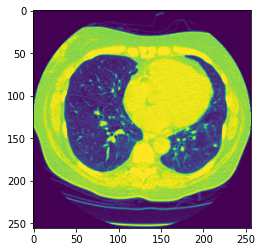

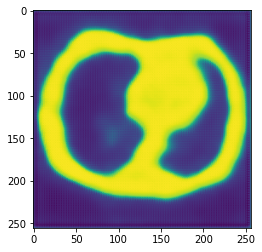

In [14]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    t = tqdm(test_dataloader, unit="batch")
    for batch_idx, (lesion, lesion_free) in enumerate(t):
        lesion = lesion.to(device)
        lesion_free = lesion_free.to(device)
        
        
        mean, logvar = model.encode(lesion)
        z = model.reparameterize(mean, logvar)
        x_logit = model.decode(z, apply_sigmoid=True)
        
        plt.figure()
        plt.imshow(lesion.cpu()[0][0])
        plt.figure()
        plt.imshow(x_logit.cpu()[0][0])
        break
        

In [ ]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
  with tqdm.tqdm(test_dataloader, unit="batch") as tepoch:
    for batch_idx, (lesion, lesion_free, _) in enumerate(tepoch):
      lesion = lesion.to(device)
      lesion_free = lesion_free.to(device)
      recon, mu, logvar = model(lesion)
      if batch_idx % 10 == 0:
        tepoch.set_description(f"Validation loss: {loss / len(lesion)}")
        plt.imshow(recon[0][0].cpu().numpy())
        plt.show()
        plt.imshow(lesion_free[0][0].cpu().numpy())
        plt.show()
        plt.imshow(lesion[0][0].cpu().numpy())
        plt.show()
        break

## Module 3: Prior UNet